## 20/02/2021 

The PCA model was used in a way which required the need to generate decision variables in real time. This is not desirable for the online mode of operation of this classifier.

Can set up the model to instead train from the entire 2000 training samples, then it does not need to generate any decision variable value during inference time. 

To do this need to have the PCA set up to take the time frequency domainm spectrograms. 

However, the PCA takes vectors as inputs, so need to flatten each spectrogram domain into a vector. This is non-ideal as we lose the ability to process the 2D shape of the features inside of the spectrogram. 

Instead, the PCA will simply look at the linear combinations of the features, there is no saying that it will not be able to learn the 2d shape if they are all present in the training data, however it might not place as much emphasis on detecting these 2d shapes. 

For starters create the datasets, this time it is different to the autoencoder dataloaders, 
can just load the json file and reshape the matrix so that it is in the shape we want 

the shape should be (1000*2048), can print this out to check 

The shape seems to be correct. 


In [2]:
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from tqdm import tqdm 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [3]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
SAVED_MODEL_PATH = "./models/model1.pth"

In [4]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 


    
    
X,y=load_dataset(DATA_PATH)
X_test, y_test = load_dataset(TEST_PATH)

X_test = X_test.reshape(np.shape(X_test)[0],-1)
y_test = y_test.reshape(np.shape(y_test)[0],-1)
X = X.reshape(np.shape(X)[0],-1)
y = y.reshape(np.shape(y)[0],-1)


In [5]:
print(np.shape(X))


(1000, 2048)


## 21/02/2021 

We would like to do some model optimisation on the PCA model, so leave leave a parameter here which gives the ability to be changed

for this first go we would like M to be 10, ane optimise from there 

To implement PCA, need to first define the number of components and create the corresponding PCA model. 

Calling model.fit_transform on the training data matrix will fit the model to the training data, completing training in one step 

The pca model can then use its inverse transform to reconstruct the original signal. 


## 24/02/2021 

The n_components has been changed to 12 here to visualise the best case performance for the PCA model 

In [70]:
pca_model = PCA(n_components = 12)

In [71]:
pca_model = PCA(n_components = 12)
pca_res = pca_model.fit_transform(X)

test_res = pca_model.transform(X_test)
reconstructed = pca_model.inverse_transform(test_res)



print(np.shape(reconstructed))

(600, 2048)


## 21/02/2021 

The reconstruction error can then be visualised again.

as before, place the reconstruction outputs from the unseen test dataset in separate lists according to the snr. 

The peaks seem to overlap slightly more than the autoencoder case. 

In order to compare the models, plot the distribution curve as well as the roc curve



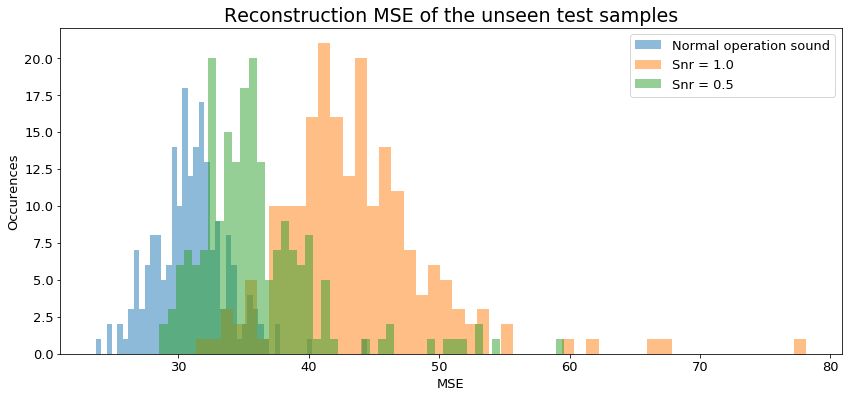

In [74]:
import matplotlib.pyplot as plt
out_list =[[] for i in range(3)]
for i, point in enumerate(reconstructed): 
    out_list[y_test[i][0]].append(np.mean(np.square(np.array(point) - np.array(X_test[i]))))
    
fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Reconstruction MSE of the unseen test samples")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = False)

ax.set_xlabel("MSE")
ax.set_ylabel("Occurences")
ax.legend()
plt.show()


## 22/02/2021 

Visualise the distribution as before. 

Need to change the threashold for the reconstruction error for the outlier cutoff, as the location of the outliers have changed. 

the overlapping area is larger than the previous model indicating that this pca based model does not perform as well as the autoencoder model.


The difference is 0.12010718625709069


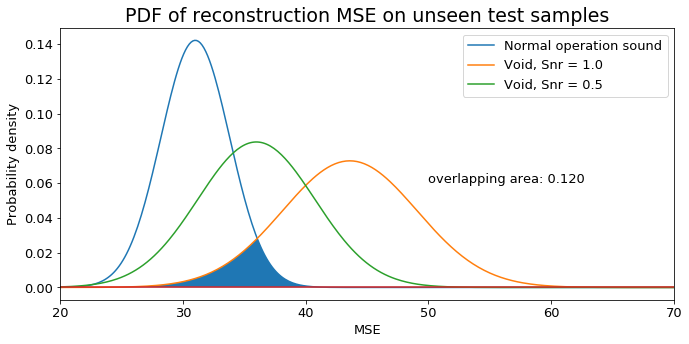

In [76]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("PDF of reconstruction MSE on unseen test samples")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("MSE")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


## 22/02/2021

The ROC curve is plotted to see what the area is. 

This is done in the same way as before. The result was that the aoc score was 0.987. 

This is lower than the results obtained by the autoencoder model. 

for the case with lower snr, it performed much worst. This is expected as the weaker the signal is compared to the noise, the more difficult it is for the classifier to classify the sample 


## 15/05/2021 

For the report it was thought that we need to make the graphs as easy to understand as possible for whoever that is reading, so for this i thought it would be good to change the code that it also shows the shaded hatch lines to indicate what is the area under the curve. Also, a theoretically perfect classifier was also plotted. 



The aoc score is 0.987 for snr =1
The aoc score is 0.843 for snr =0.5


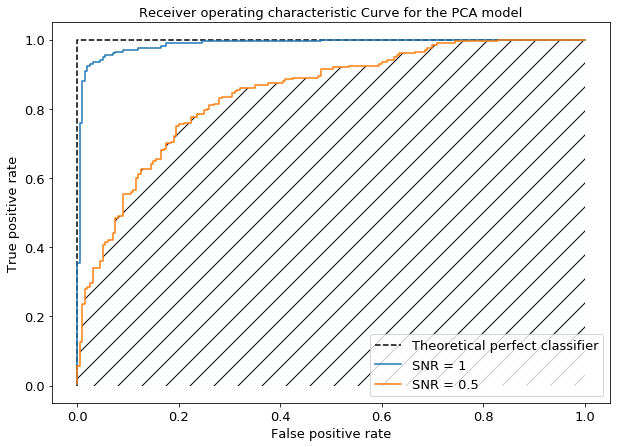

In [67]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curve for the PCA model")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1,[0]+[1 for i in range(len(fpr1)-1)],linestyle = "dashed", markersize = 7, label = "Theoretical perfect classifier", c = "black")

ax.plot(fpr1, tpr1, label = "SNR = 1")
ax.plot(fpr2, tpr2, label = "SNR = 0.5")
ax.fill_between(fpr2, tpr2, hatch = "/", alpha = 0.01)

ax.legend()

## 16/05/2021 

Did not have a principle score plot for this classifier, so need to make one for the report. The principle component scores are actually called the explained variance ratio, and is stored as a class attribute in the trained model. 

The plot can be done using matplotlib. the marker crosses were added for easier visualisation 

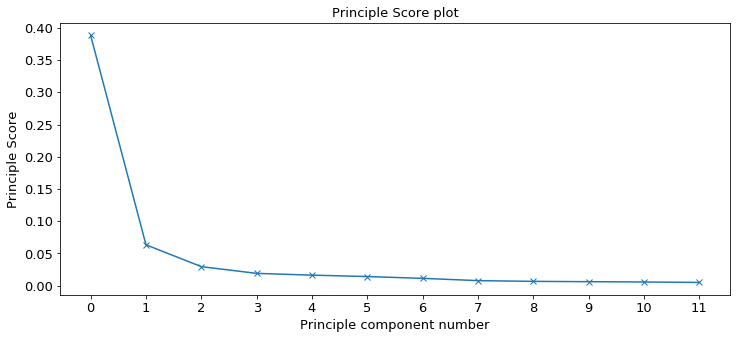

In [19]:
features = range(pca_model.n_components_)
plt.figure(figsize=(12,5))
plt.plot(features,pca_model.explained_variance_ratio_, marker = "x")
plt.xlabel('Principle component number')
plt.ylabel('Principle Score')
plt.title("Principle Score plot")
plt.xticks(features)
plt.show()



## 22/02/2021 

Model optimisation - want to see for which number of principle component it is able to achieve a best response in terms of reconstruction error. 

For this, loop a decision variable j from 1 through to 30. 

For each value of j, make a new pca model which is using the first j principle components to reconstruct. 

The resulting auc scores are calculated for each classifier and displayed. 

It was shown that the area vaires from 0.91 to around 0.988. this is a rather large range of model performance values, and shows that the optimisation process is necessary and useful. 

the pca model with a 12 principle components was the best performing configuration , and the previous run will be updated to use this optimal parameter, so that all the graphs and curves shown in the report will be for the best performing model. 

In [80]:
l1 = []
l2 = []
for j in range(20):
    pca_model = PCA(n_components = j)
    pca_res = pca_model.fit_transform(X)

    test_res = pca_model.transform(X_test)
    reconstructed = pca_model.inverse_transform(test_res)
    out_list =[[] for i in range(3)]
    for i, point in enumerate(reconstructed): 
        out_list[y_test[i][0]].append(np.mean(np.square(np.array(point) - np.array(X_test[i]))))

    scores1 = out_list[0]+out_list[1]
    y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
    fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)
    scores2 = out_list[0]+out_list[2]
    y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
    fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

    aoc_snr2 = roc_auc_score(y2,scores2)
    aoc_snr1 = roc_auc_score(y1,scores1)
    l2.append(aoc_snr2)
    l1.append(aoc_snr1)
    print(f"The aoc score is {aoc_snr1:.3f}, {aoc_snr2:.3f}, for n_components ={j}")
    
    


The aoc score is 0.913, 0.912, for n_components =0
The aoc score is 0.961, 0.793, for n_components =1
The aoc score is 0.910, 0.688, for n_components =2
The aoc score is 0.953, 0.751, for n_components =3
The aoc score is 0.964, 0.779, for n_components =4
The aoc score is 0.970, 0.788, for n_components =5
The aoc score is 0.980, 0.822, for n_components =6
The aoc score is 0.985, 0.844, for n_components =7
The aoc score is 0.986, 0.848, for n_components =8
The aoc score is 0.985, 0.841, for n_components =9
The aoc score is 0.985, 0.847, for n_components =10
The aoc score is 0.987, 0.843, for n_components =11
The aoc score is 0.989, 0.855, for n_components =12
The aoc score is 0.988, 0.851, for n_components =13
The aoc score is 0.987, 0.845, for n_components =14
The aoc score is 0.988, 0.842, for n_components =15
The aoc score is 0.987, 0.841, for n_components =16
The aoc score is 0.984, 0.833, for n_components =17
The aoc score is 0.984, 0.833, for n_components =18
The aoc score is 0.983

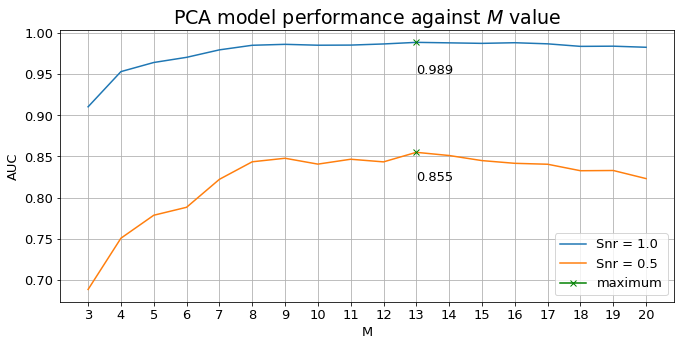

In [101]:
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("PCA model performance against $M$ value")
ax.title.set_fontsize(19)
labels = ["Snr = 1.0", "Snr = 0.5"]
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 15
x = range(1,21)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax.set_xlabel("M")
ax.set_ylabel("AUC")
ax.set_xticks(x)
ax.plot(x[2:],l1[2:], label = labels[0])
ax.plot(x[2:],l2[2:],  label = labels[1])
ax.plot(13,l1[12], marker = "x", c = "g", label = "maximum")
ax.plot(13,l2[12], marker = "x", c = "g")
ax.text(13,0.82,f"{l2[12]:.3f}")
ax.text(13,0.95,f"{l1[12]:.3f}")

ax.grid()
ax.legend()

## 14/03/2021 

It was thought that for model performance comparison it might be usefull to plot the pca and autoencoder roc curves on the same plot. 

This requires the data from the autoencoder experiements to be saved and loaded into this notebook. 

how this could be done was thought about and it was decided to use the pickple module. 

The plotted roc curves seem a little difficult to understand, as the reader need to look at the curves, identify which one is which and then integrate for the area, beofre they can compare model performance, maybe it is just easier to list all the auc values in a table. 

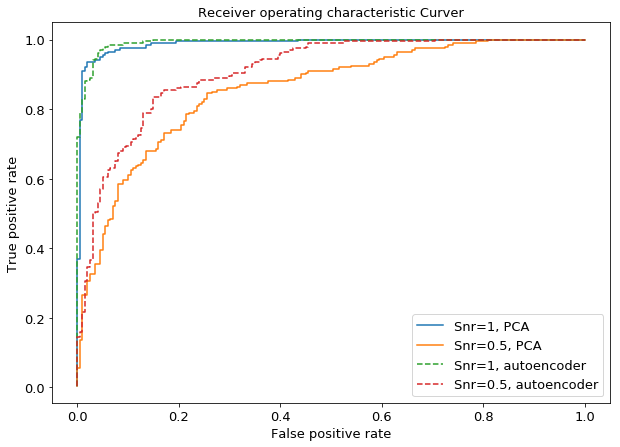

In [57]:
import pickle 

with open("auto_roc.txt", "rb") as f: 
    auto_data = pickle.load(f)


fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curver")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1, tpr1,label = "Snr=1, PCA")
ax.plot(fpr2, tpr2,label = "Snr=0.5, PCA")
ax.plot(auto_data["fpr1"], auto_data["tpr1"], linestyle = "dashed", label = "Snr=1, autoencoder")
ax.plot(auto_data["fpr2"], auto_data["tpr2"],linestyle = "dashed",label = "Snr=0.5, autoencoder")
ax.legend() 
plt.show()

## 24/02/2021

The performance of the pca classifier seems to be decents, so again we can visualise the performance on the spectrogram containing 10 seconds of normal operation sound with 5 voids. 

The same slicing process was used to generate the temporal resolution. 
it can be seen that towards t = 7.5 the model gets quite confused at the normal operation sound. This region contains some motor noises and is rightfully confusing. The model seems to be unable to appreciate the short timed nature of the void response. 


also, the pca is a linear process so that it is expected to extract only simpler features. a stripe in the spectrogram from the  motor may be too confusing for the model. 

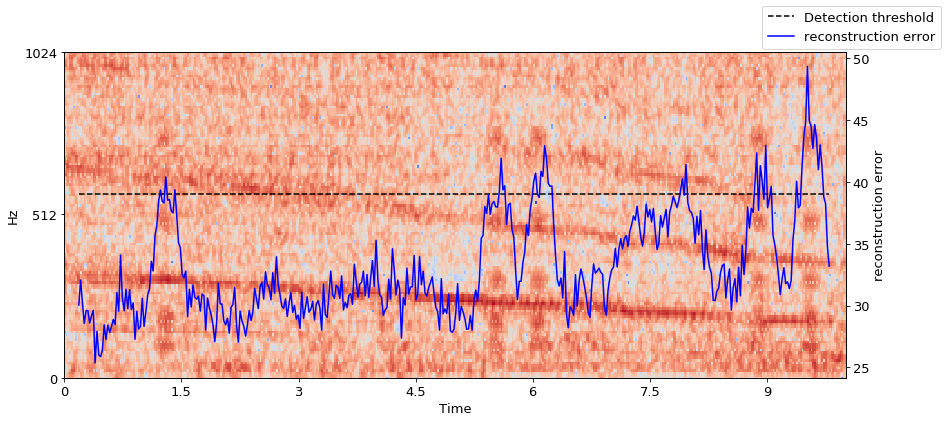

In [42]:
import librosa
test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    piece  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    piece = np.ndarray.flatten(piece)
    test_res = pca_model.transform([piece])
    reconstructed = pca_model.inverse_transform(test_res)
    score.append(np.sum(np.square(np.subtract(piece,reconstructed)))/(2048))
    
    i+= 512
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.set_ylabel("reconstruction error")
ax2.plot(x,[39 for i in range(len(x))],linestyle = "dashed", markersize = 7, label = "Detection threshold", c = "black")
ax2.plot(x,score, c="blue", label = "reconstruction error")
fig.legend()


## 24/02/2020 

The input and reconstructed spectrograms should be plotted again to see the differnce and effects of the reconstruction process. 
The reconstructed spectrogram seems to only retain the stripe features, compared to the autoencoder model which is able to also retain blob like features. this shows that the pca model was lacking the ability to extract 2d features as well as the autoencoder.


## 20/05/2020 

The input and reconstructed spectrograms have been plotted before but they need to be formatted nicely. 

The librosa plotting library was used for this.

axis labels changed to be easier on the readers. 

The report progress at this point is  about 50% 

-13.038728907598848 10.790628346543869
-30.917673 29.62992


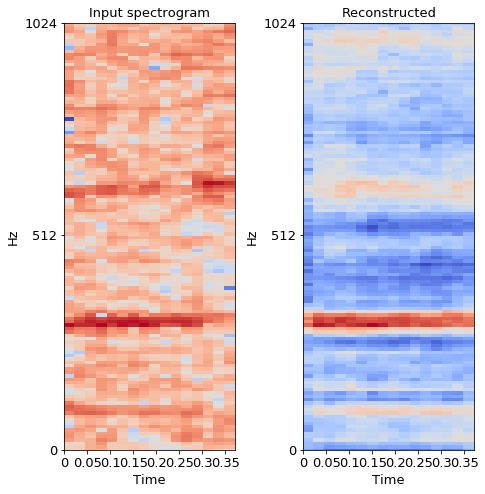

In [105]:
fig, axs = plt.subplots(1,2,figsize = (7,7))
fig.tight_layout(pad=2.0)
img, sr = librosa.load(path  = "./data/synthetic/train_sounds/normal/n23.wav")
f_max = 1024
n_mels = 128

xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(img, n_mels = n_mels,fmax = f_max)))

piece = np.ndarray.flatten(xt)
test_res = pca_model.transform([piece])
reconstructed = pca_model.inverse_transform(test_res)
reconstructed = np.reshape(reconstructed, (128,16))
reconstructed = reconstructed -14
librosa.display.specshow(xt, y_axis = "mel",x_axis = "time", fmax = 1024, ax = axs[0])
print(np.min(reconstructed),np.max(reconstructed))
print(np.min(xt),np.max(xt))

axs[1].set_title("Reconstructed")
axs[0].set_title("Input spectrogram")

librosa.display.specshow(reconstructed, y_axis = "mel",x_axis= "time", fmax = 1024, ax = axs[1])